# Preprocessing and Modelling 3

In [24]:
import pandas as pd

import pickle as pkl

import sys
sys.path.append('../..')


from src.support_encoding import *
from src.support_pre import *
from src.support_plots import * 
from src.support_model import *

Comparando con la iteración anterior, vamos a incluir `municipality`.

In [25]:
df = pd.read_csv("../../datos/clean_data.csv", index_col = 0)
df.drop(columns=["numPhotos", "hasPlan", "newDevelopment", "isParkingSpaceIncludedInPrice", "hasParkingSpace", "has3DTour"], inplace=True)
df.drop(index = df[df["province"] == "Segovia"].index, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,price,propertyType,size,exterior,rooms,bathrooms,province,municipality,showAddress,distance,hasVideo,status,has360,floor,hasLift
0,550.0,chalet,371.0,False,6,3,Toledo,Numancia de la Sagra,False,40116,False,good,False,unknown,unknown
1,750.0,flat,60.0,True,1,1,Madrid,Madrid,True,7037,False,good,False,3,True
2,750.0,flat,70.0,True,2,1,Madrid,San Sebastián de los Reyes,False,16145,True,good,False,bj,False
3,400.0,penthouse,67.0,True,2,2,Madrid,Villamanrique de Tajo,False,55041,False,good,True,2,False
4,450.0,flat,89.0,False,2,1,Toledo,Recas,False,47186,False,good,False,2,True


In [26]:
df[df.select_dtypes("bool").columns] = df.select_dtypes("bool").astype("str")

In [27]:
df[["rooms", "bathrooms"]] = df[["rooms", "bathrooms"]].astype("str")

In [28]:
num_cols = df.select_dtypes("number").columns
cat_cols = df.select_dtypes("O").columns

df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     434 non-null    float64
 1   size      434 non-null    float64
 2   distance  434 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 10.3 KB


In [29]:
df[cat_cols].head()

,propertyType,exterior,rooms,bathrooms,province,municipality,showAddress,hasVideo,status,has360,floor,hasLift
0,chalet,False,6,3,Toledo,Numancia de la Sagra,False,False,good,False,unknown,unknown
1,flat,True,1,1,Madrid,Madrid,True,False,good,False,3,True
2,flat,True,2,1,Madrid,San Sebastián de los Reyes,False,True,good,False,bj,False
3,penthouse,True,2,2,Madrid,Villamanrique de Tajo,False,False,good,True,2,False
4,flat,False,2,1,Toledo,Recas,False,False,good,False,2,True


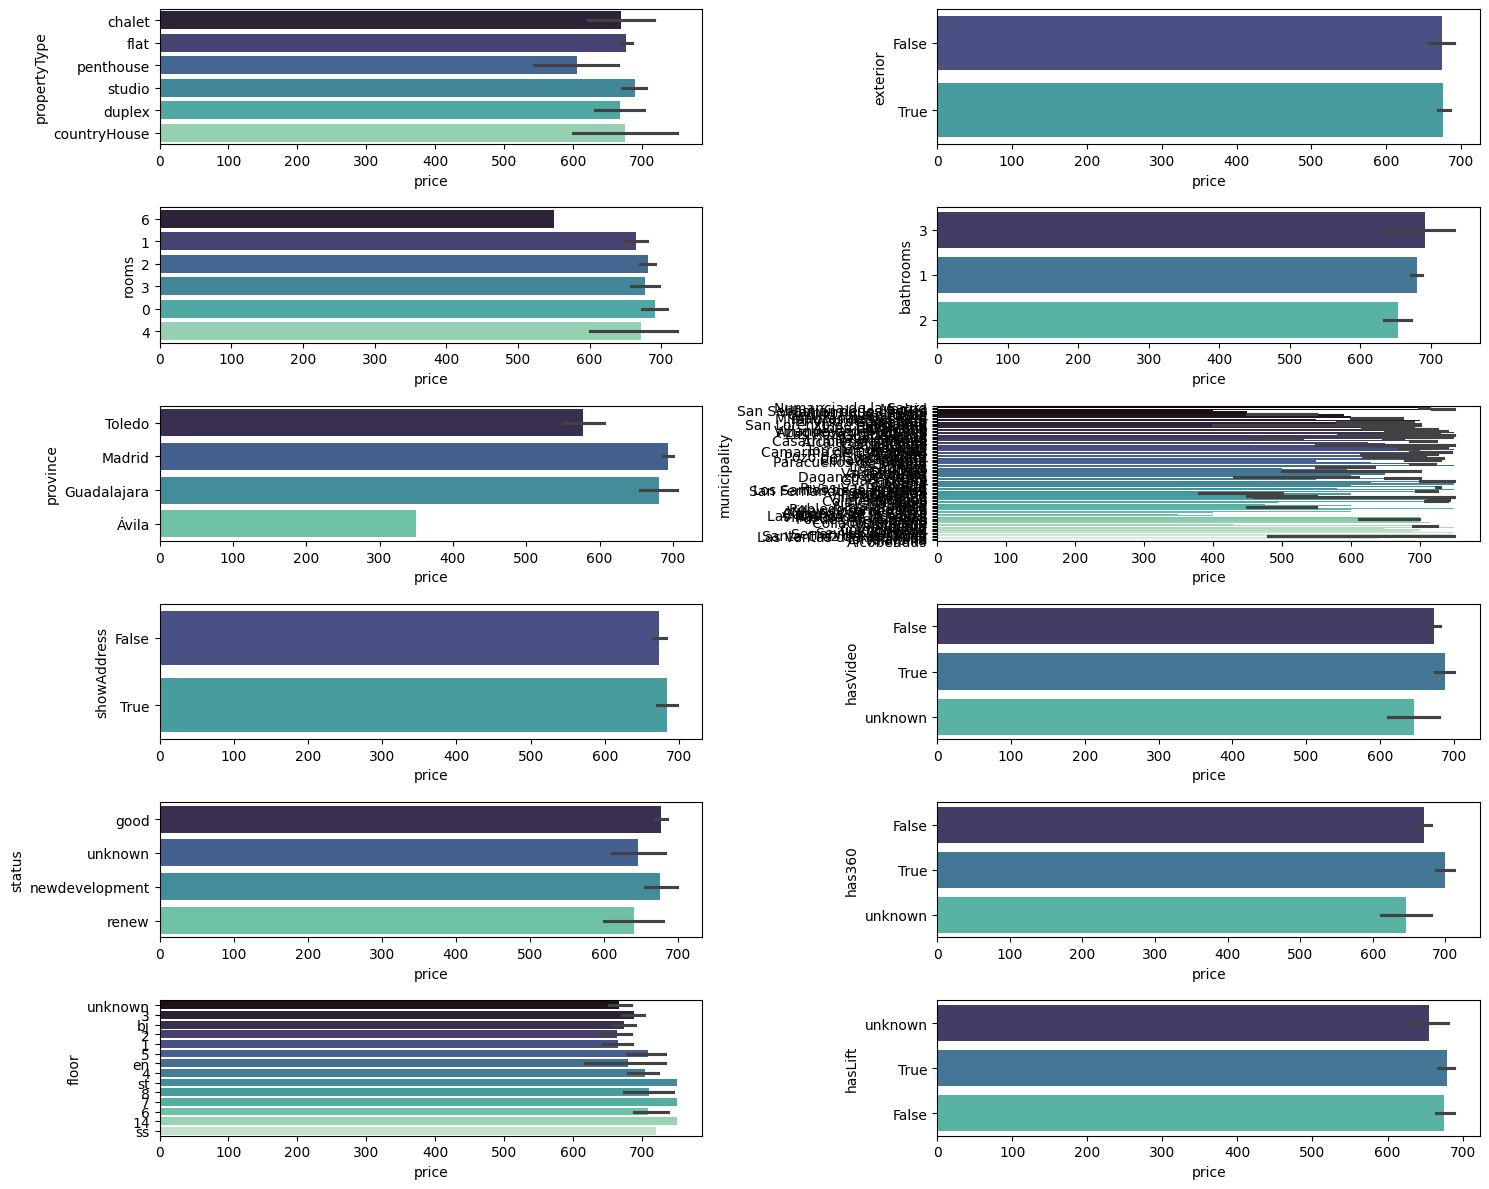

In [30]:
plot_cats(data = df, columns = cat_cols, rv = "price")

In [31]:
# asunciones = Asunciones(dataframe=df, columna_numerica="price")


# for categoria in cat_cols:   

#     print(f"Estamos analizando la variable {categoria.upper()}")
    
#     asunciones.identificar_normalidad(metodo = "shapiro") 

#     # comprobamos la homogeneidad de varianzas
#     asunciones.identificar_homogeneidad(columna_categorica = categoria)

#     # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
#     test = TestEstadisticos(df, "price", categoria)
#     test.run_all_tests()
#     print("\n###########################\n")

Vemos que además de lo mencionado en notebooks anteriores, vemos (como era de esperar) diferencias entre las diferentes categorías de municipality.

In [32]:
cat_cols_ordinal = ["has360", "province", "bathrooms", "rooms", "municipality"]
cat_cols_nominal = cat_cols.drop(cat_cols_ordinal)

#### Encoding

In [33]:
onehot_df, oh_encoder = encode_onehot(df, cat_cols_nominal)

In [35]:
df_w_target, target_encoder = encode_target(df, cat_cols_ordinal, "price")

In [36]:
df_encoded = pd.concat([df[num_cols], df_w_target, onehot_df], axis = 1)
df_encoded.head()

,price,size,distance,has360,province,bathrooms,rooms,municipality,propertyType_chalet,propertyType_countryHouse,...,floor_7,floor_8,floor_bj,floor_en,floor_ss,floor_st,floor_unknown,hasLift_False,hasLift_True,hasLift_unknown
0,550.0,371.0,40116,671.176292,579.743213,679.027033,659.528162,659.528162,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,750.0,60.0,7037,671.176292,692.932011,680.495726,664.363794,705.594109,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,750.0,70.0,16145,671.176292,692.932011,680.495726,681.088234,687.763912,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,400.0,67.0,55041,699.901503,692.932011,653.853023,681.088234,640.011891,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,450.0,89.0,47186,671.176292,579.743213,680.495726,681.088234,646.517315,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Feature Scaling

In [37]:
df_scaled_cols, scaler = scale_data(data = df_encoded, columns = df_encoded.columns.drop(onehot_df.columns).drop("price"), method = "standard")
df_scaled = pd.concat([df_encoded["price"], df_scaled_cols, onehot_df], axis = 1)

#### Outliers

In [39]:
df_outliers, outlier_finder = find_outliers(data = df_scaled, columns=df_scaled.columns, method = "ifo", threshold=60)
df_outliers.head()

100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


,price,size,distance,has360,province,bathrooms,rooms,municipality,propertyType_chalet,propertyType_countryHouse,...,floor_7,floor_8,floor_bj,floor_en,floor_ss,floor_st,floor_unknown,hasLift_False,hasLift_True,hasLift_unknown
0,550.0,8.434820,1.127206,-0.457772,-2.506457,0.322369,-1.925467,-1.494667,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,400.0,-0.021407,2.036313,1.976257,0.419253,-2.152916,0.572301,-2.567070,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,684.0,-0.633371,-0.667252,-1.184851,0.419253,0.466782,1.613733,1.036619,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
36,750.0,0.757456,0.781715,-1.184851,-2.506457,-2.152916,0.099624,-0.429821,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
66,750.0,-0.911536,-1.069817,-1.184851,0.419253,0.466782,-1.365252,1.036619,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [40]:
df_scaled.loc[df_outliers.index, num_cols.drop('price')] = np.nan

In [41]:
df_out_imputed, outlier_imputer = impute_nulls(data=df_scaled)

[IterativeImputer] Completing matrix with shape (434, 42)
[IterativeImputer] Ending imputation round 1/10, elapsed time 4.60
[IterativeImputer] Change: 3.2644675828168754, scaled tolerance: 0.75 
[IterativeImputer] Ending imputation round 2/10, elapsed time 9.31
[IterativeImputer] Change: 0.7982484207693604, scaled tolerance: 0.75 
[IterativeImputer] Ending imputation round 3/10, elapsed time 13.76
[IterativeImputer] Change: 0.5582782492149343, scaled tolerance: 0.75 
[IterativeImputer] Early stopping criterion reached.


In [42]:
display(df_scaled[num_cols].describe())
df_out_imputed[num_cols].describe()

,price,size,distance
count,434.000000,410.000000,410.000000
mean,675.910138,-0.079890,-0.040950
std,81.339387,0.747250,0.975467
min,340.000000,-1.328784,-1.305180
25%,650.000000,-0.605554,-0.898031
50%,700.000000,-0.188306,-0.202922
75%,740.000000,0.312391,0.644709
max,750.000000,4.512688,2.298842


,price,size,distance
count,434.000000,434.000000,434.000000
mean,675.910138,-0.042420,-0.007389
std,81.339387,0.780563,0.985859
min,340.000000,-1.328784,-1.305180
25%,650.000000,-0.605554,-0.891224
50%,700.000000,-0.160490,-0.120539
75%,740.000000,0.340208,0.795009
max,750.000000,4.512688,2.298842


In [43]:
df_out_imputed.to_csv("../../datos/Iteration3/prepped_data.csv")

In [44]:
X = df_out_imputed.drop(columns="price")
y = df_out_imputed["price"]

,R2,MAE,RMSE
Train,0.670794,35.059923,46.564249
Test,0.586830,40.376515,52.312624


{'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 8, 'min_samples_split': 20}


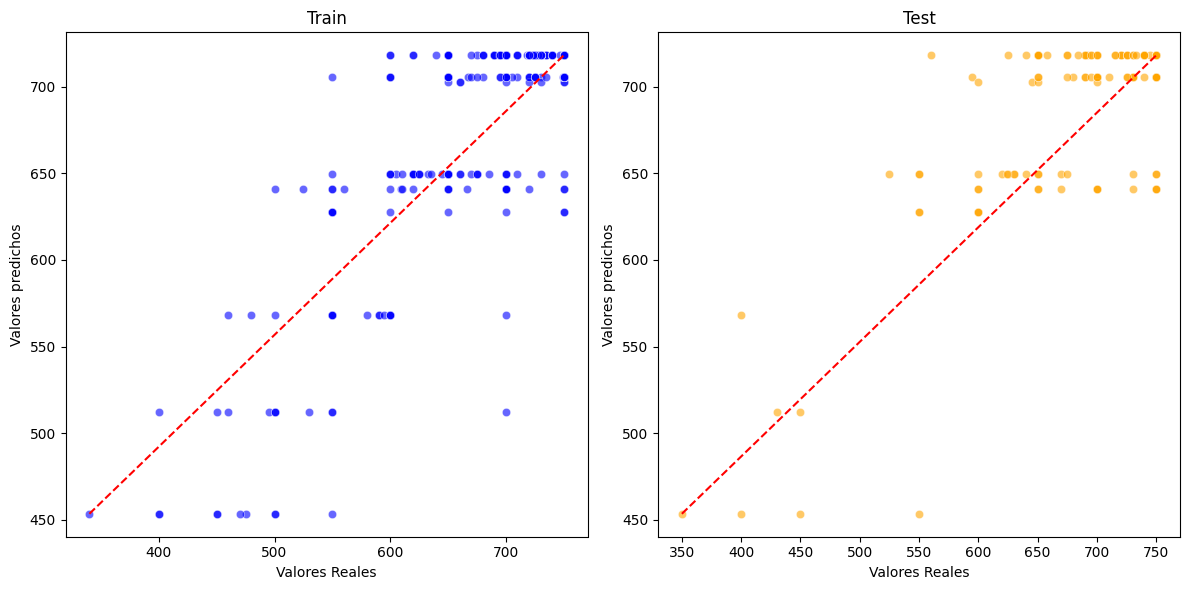

In [45]:
reg_model_dt = RegressionModel(X, y, test_size=0.3, random_state=42)

params_rf = {'max_depth': [4, 10, 14, 25, 40],
            'min_samples_split': [6, 8, 10, 15, 20, 25],
            'min_samples_leaf': [6, 8, 10, 15, 20, 25],
            'max_leaf_nodes': [10, 15, 20, 25, 40, 60, 90, 110]}

metrics_rf = reg_model_dt.train("decision_tree", params=params_rf)
reg_model_dt.display_metrics()

print(reg_model_dt.get_best_params())
reg_model_dt.plot_residuals()

,R2,MAE,RMSE
Train,0.661155,35.658661,47.240995
Test,0.646643,38.417726,48.378093


{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}


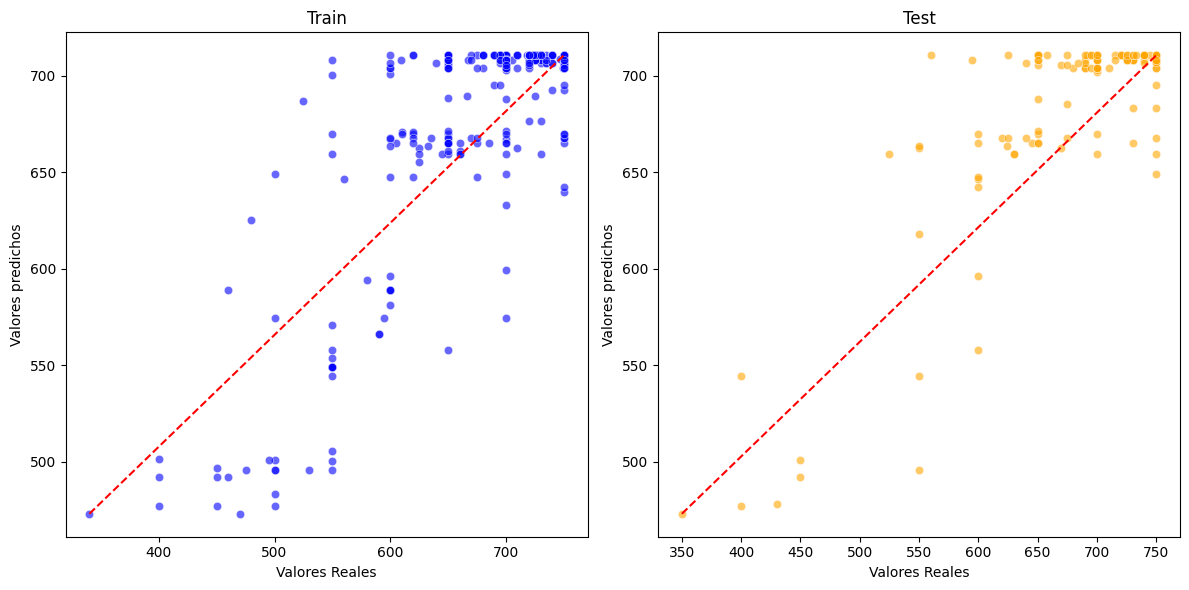

In [46]:
reg_model_rf = RegressionModel(X, y, test_size=0.3, random_state=42)

params_rf = {'n_estimators': [x for x in range(10,90,10)],
            'max_depth': [x for x in range(1,9)],
            'min_samples_split': [x for x in range(3,6)],
            'min_samples_leaf': [x for x in range(3,6)],
            'max_leaf_nodes': [x for x in range(3,6)]}

metrics_rf = reg_model_rf.train("random_forest", params=params_rf)
reg_model_rf.display_metrics()

print(reg_model_rf.get_best_params())
reg_model_rf.plot_residuals()

,R2,MAE,RMSE
Train,0.777118,29.75698,38.313888
Test,0.669621,34.71450,46.778675


{'max_depth': 2, 'max_features': 10, 'max_leaf_nodes': 3, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 50}


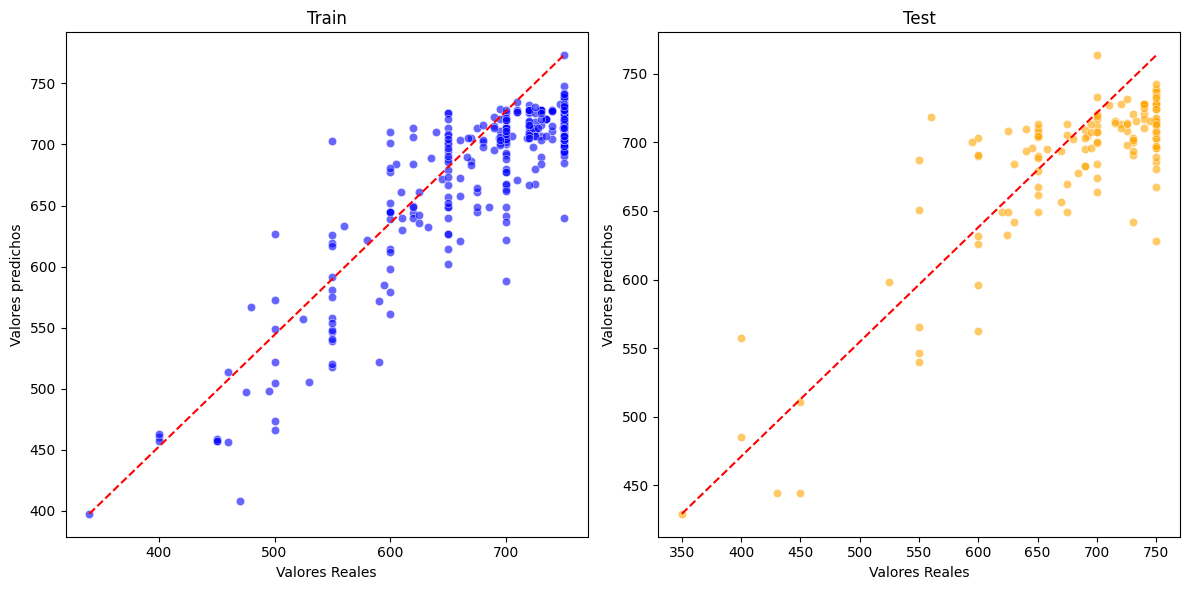

In [47]:
reg_model_gb = RegressionModel(X, y, test_size=0.3, random_state=42)

params_gb = {'n_estimators': [x for x in range(20,60,10)],
            'max_depth': [x for x in range(1,5)],
            'min_samples_split': [x for x in range(3,7)],
            'min_samples_leaf': [x for x in range(3,7)],
            'max_leaf_nodes': [x for x in range(3,7)], 
            'max_features' : [10,20,40]}

metrics_rf = reg_model_gb.train("gradient_boosting", params=params_gb, learning_rate=0.3)
reg_model_gb.display_metrics()

print(reg_model_gb.get_best_params())
reg_model_gb.plot_residuals()

In [49]:
importances = pd.DataFrame(reg_model_gb.return_model().feature_importances_, index = X.columns, columns=["Importance"]).sort_values(by = "Importance", ascending=False)

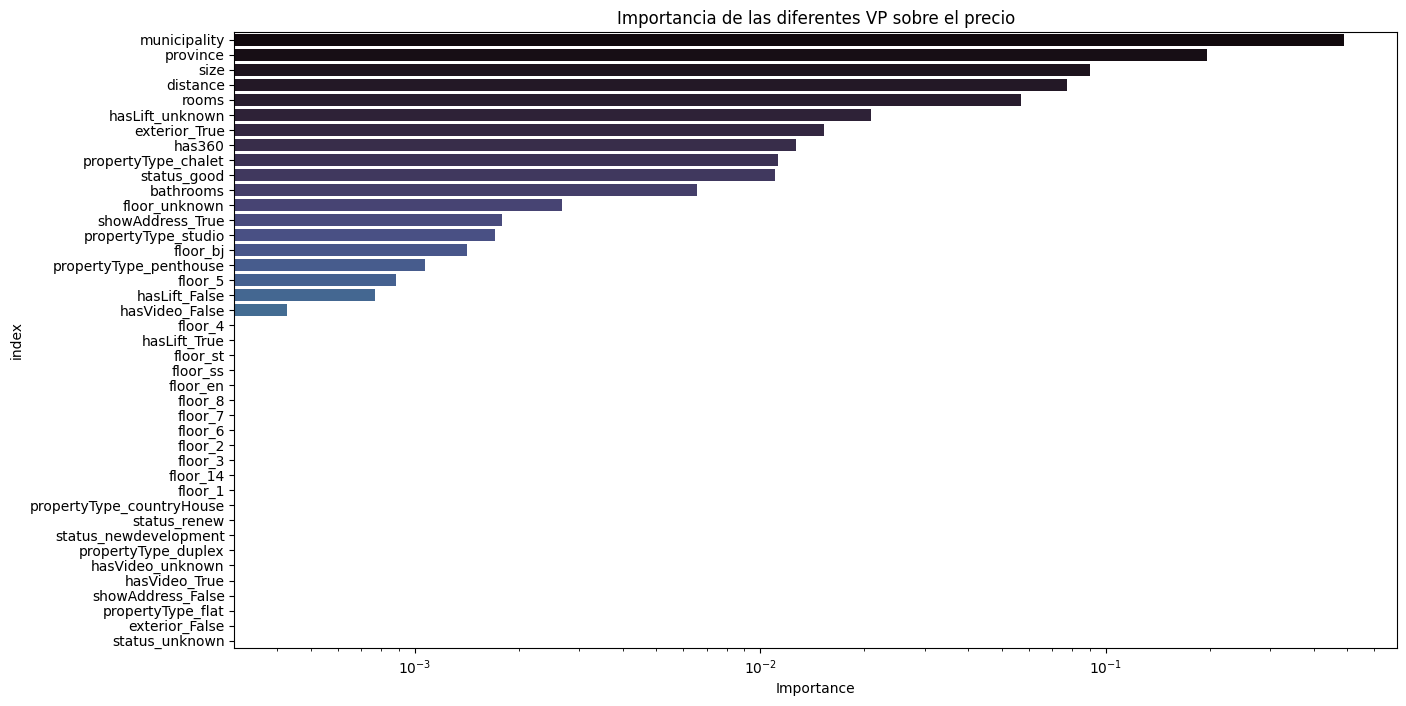

In [50]:
plt.figure(figsize = (15,8))
plt.title("Importancia de las diferentes VP sobre el precio")
sns.barplot(importances.reset_index(), x = "Importance", y = "index", palette = "mako")
plt.xscale("log")
plt.show()

Vemos que lo que más influye en el precio de nuestras viviendas es el municipio, seguido de la distancia del centro y el tamaño de la propiedad. Esto indica que más que las características de la casa, la ubicación de esta es la que determina su precio.

## Conclusiones

Vemos que, a pesar de seguir teniendo overfitting, el modelo ya se ajusta mucho mejor. Nos quedaremos con éste último.

In [74]:

params_gb = {'n_estimators': [x for x in range(20,60,10)],
            'max_depth': [x for x in range(1,5)],
            'min_samples_split': [x for x in range(3,7)],
            'min_samples_leaf': [x for x in range(3,7)],
            'max_leaf_nodes': [x for x in range(3,7)], 
            'max_features' : [10,20,40]}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42, learning_rate=0.3),
                            param_grid=params_gb, cv=5, scoring="r2", n_jobs=-1)

grid_search.fit(X, y)
reg_model_final = grid_search.best_estimator_

In [84]:
y_pred = reg_model_final.predict(X)

metrics = pd.DataFrame([r2_score(y, y_pred), mean_absolute_error(y, y_pred), root_mean_squared_error(y, y_pred)], index=["R2", "MAE", "RMSE"]).T
metrics.to_csv("../../datos/metricas_finales.csv")
metrics

,R2,MAE,RMSE
0,0.782437,29.151103,37.895921


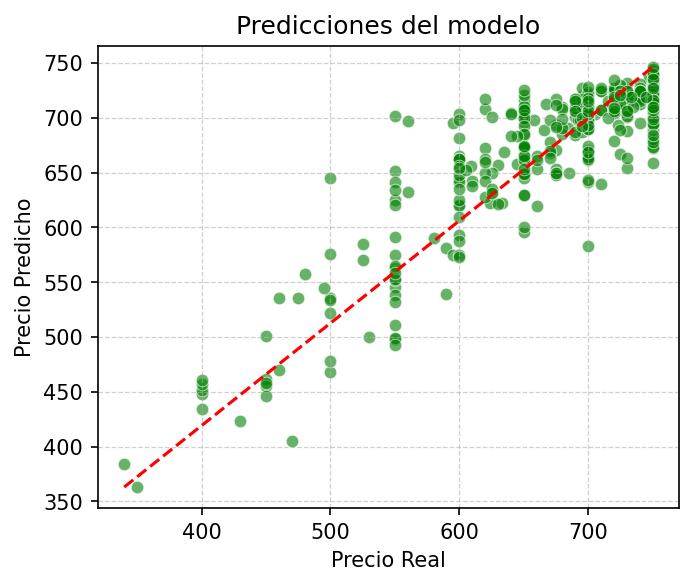

In [103]:
plt.figure(dpi = 150, figsize=(5,4))
plt.grid(ls = "--", alpha = 0.6, lw = 0.6)
plt.title("Predicciones del modelo")
sns.scatterplot(x = y, y = y_pred, color = "green", alpha = 0.6)
plt.plot([min(y), max(y)], [min(y_pred), max(y_pred)], ls = "--", color = "red")
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.show()

In [79]:
with open('../../models/model.pkl', 'wb') as f:
    pkl.dump(reg_model_final, f)

with open('../../models/encoder_target.pkl', 'wb') as f:
    pkl.dump(target_encoder, f)

with open('../../models/encoder_onehot.pkl', 'wb') as f:
    pkl.dump(oh_encoder, f)

with open('../../models/scaler.pkl', 'wb') as f:
    pkl.dump(scaler, f)